In [1]:
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [2]:
data = pd.read_csv('Data/student_exam_data.csv')
print('############ Read data ############\n')
print(data.head())

############ Read data ############

   Study Hours  Previous Exam Score  Pass/Fail
0     4.370861            81.889703          0
1     9.556429            72.165782          1
2     7.587945            58.571657          0
3     6.387926            88.827701          1
4     2.404168            81.083870          0


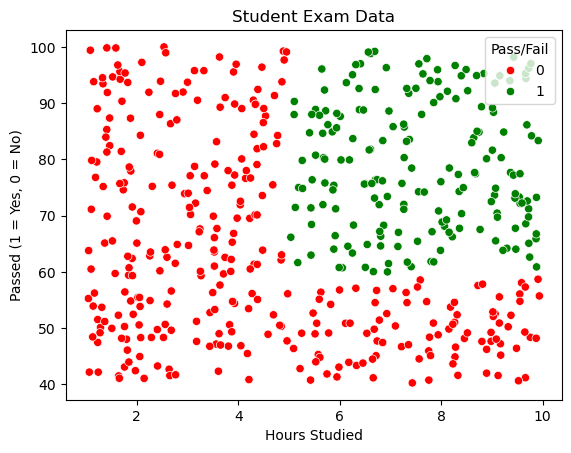

In [3]:
color = {'Pass/Fail': {0: 'red', 1: 'green'}}

sns.scatterplot(x='Study Hours', y='Previous Exam Score', data=data, hue='Pass/Fail', palette=color['Pass/Fail'])
plt.title('Student Exam Data')
plt.xlabel('Hours Studied')
plt.ylabel('Passed (1 = Yes, 0 = No)')
plt.show() 

In [4]:
# Split randomly the data into training and test sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=35)

print('\n############ Train/Test split ############\n')
print(f'Training data size: {train_data.shape[0]} samples')
print(f'Test data size: {test_data.shape[0]} samples')

# Training data
X_train = train_data[['Study Hours', 'Previous Exam Score']]
y_train = train_data['Pass/Fail']

# Test data
X_test = test_data[['Study Hours', 'Previous Exam Score']]
y_test = test_data['Pass/Fail']


############ Train/Test split ############

Training data size: 400 samples
Test data size: 100 samples


In [5]:
def feature_mapping(x1, x2, degree=6):
    """
    Maps the two input features to polynomial features up to the specified degree.
    
    Parameters:
    x1 -- First feature (numpy array or pandas Series)
    x2 -- Second feature (numpy array or pandas Series)
    degree -- The maximum degree of polynomial features to generate
    
    Returns:
    A numpy array with the mapped features.
    """
    if len(x1.shape) == 1:
        x1 = x1[:, np.newaxis]
    if len(x2.shape) == 1:
        x2 = x2[:, np.newaxis]
        
    out = np.ones((x1.shape[0], 1))  # Start with the bias term (intercept)
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            term = (x1 ** (i - j)) * (x2 ** j)
            out = np.hstack((out, term))
    
    return out

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y, lambda_):
    m = len(y)
    h = sigmoid(X.dot(theta))
    
    # Compute the cost
    term1 = -y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    cost = (1/m) * np.sum(term1 - term2)
    
    # Regularization (excluding the bias term)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    total_cost = cost + reg_term
    
    return total_cost

def gradient(theta, X, y, lambda_):
    m = len(y)
    h = sigmoid(X.dot(theta))
    error = h - y
    grad = (1/m) * (X.T.dot(error))
    
    # Regularization (excluding the bias term)
    reg_term = (lambda_ / m) * theta
    reg_term[0] = 0  # No regularization for the bias term
    grad += reg_term
    
    return grad


In [6]:
degree = 4

normal_X_train = (X_train - X_train.mean()) / X_train.std()
normal_X_test = (X_test - X_test.mean()) / X_test.std()

X_with_intercept = feature_mapping(normal_X_train['Study Hours'].values, normal_X_train['Previous Exam Score'].values, degree=degree)
print("Mapped feature shape:", X_with_intercept.shape)
y = train_data['Pass/Fail'].values
initial_theta = np.zeros(X_with_intercept.shape[1])
lambda_ = 0.1

Mapped feature shape: (400, 15)


In [7]:
minimize_compute = minimize(fun=cost_function, 
                  x0=initial_theta, 
                  args=(X_with_intercept, y, lambda_),
                  jac=gradient)



/tmp/ipykernel_15461/1641778145.py:36: RuntimeWarning: divide by zero encountered in log
  term2 = (1 - y) * np.log(1 - h)
/tmp/ipykernel_15461/1641778145.py:36: RuntimeWarning: invalid value encountered in multiply
  term2 = (1 - y) * np.log(1 - h)
/tmp/ipykernel_15461/1641778145.py:36: RuntimeWarning: divide by zero encountered in log
  term2 = (1 - y) * np.log(1 - h)
/tmp/ipykernel_15461/1641778145.py:36: RuntimeWarning: invalid value encountered in multiply
  term2 = (1 - y) * np.log(1 - h)


/tmp/ipykernel_15461/320984429.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = mapped_feature.dot(minimize_compute.x)


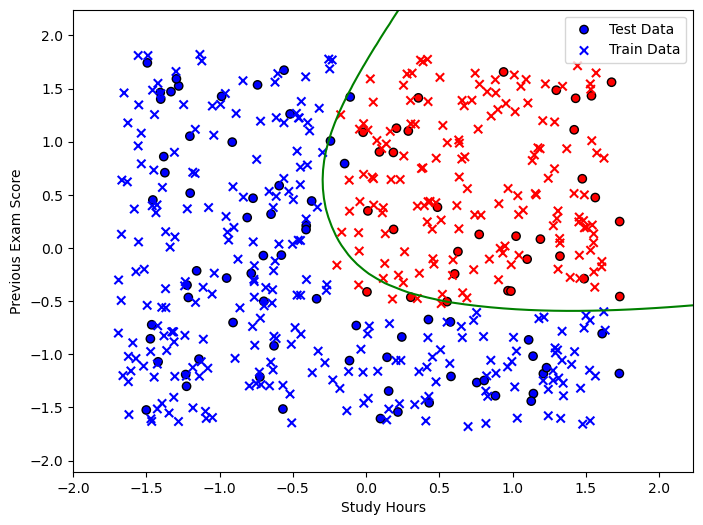

In [9]:
plt.figure(figsize=(8,6))
# Create a grid of values
u = np.linspace(normal_X_test['Study Hours'].min()-0.5, normal_X_test['Study Hours'].max()+0.5, 50)
v = np.linspace(normal_X_test['Previous Exam Score'].min()-0.5, normal_X_test['Previous Exam Score'].max()+0.5, 50)
z = np.zeros((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        mapped_feature = feature_mapping(np.array([u[i]]), np.array([v[j]]), degree=degree)
        z[i,j] = mapped_feature.dot(minimize_compute.x)
z = z.T

acepted = data[data['Pass/Fail'] == 1]
not_acepted = data[data['Pass/Fail'] == 0]

# Plot the decision boundary
plt.contour(u, v, z, levels=[0], colors='green')
plt.xlabel('Study Hours')
plt.ylabel('Previous Exam Score')
plt.scatter(normal_X_test['Study Hours'], normal_X_test['Previous Exam Score'], c=y_test, cmap='bwr', edgecolors='k', label='Test Data')
plt.scatter(normal_X_train['Study Hours'], normal_X_train['Previous Exam Score'], c=y_train, cmap='bwr', marker='x', label='Train Data')
plt.legend()
plt.show()

In [10]:
print('\n############ Model training ############\n')
print('Model coefficients:')
for i, coef in enumerate(minimize_compute.x):
    print(f'Theta {i}: {coef}')


############ Model training ############

Model coefficients:
Theta 0: 0.4387730613792801
Theta 1: 2.6887840866103363
Theta 2: 1.6881206961280035
Theta 3: -0.3729481691095656
Theta 4: 1.4798416610615763
Theta 5: -0.7729962686701108
Theta 6: 2.12810664893843
Theta 7: 1.3253945169709493
Theta 8: 1.281235102315354
Theta 9: 1.7257745539857912
Theta 10: -0.4390088287820866
Theta 11: 1.5513585468263424
Theta 12: -0.9120353659577595
Theta 13: 2.0150014450076132
Theta 14: -1.0912662152004828


In [13]:
# Print the explicit expression of the equation of f(x) but give mix terms as well
print('\n############ Model equation ############\n')
print('Model equation:')
equation_terms = []
for i in range(degree + 1):
    for j in range(i + 1):
        coef_index = int((i * (i + 1)) / 2 + j)
        coef = minimize_compute.x[coef_index]
        term = f"{coef:.4f} * (Study_Hours^{i - j}) * (Previous_Exam_Score^{j})"
        equation_terms.append(term)

equation = ' + '.join(equation_terms)
print(f'f(x) = {equation}\n')


############ Model equation ############

Model equation:
f(x) = 0.4388 * (Study_Hours^0) * (Previous_Exam_Score^0) + 2.6888 * (Study_Hours^1) * (Previous_Exam_Score^0) + 1.6881 * (Study_Hours^0) * (Previous_Exam_Score^1) + -0.3729 * (Study_Hours^2) * (Previous_Exam_Score^0) + 1.4798 * (Study_Hours^1) * (Previous_Exam_Score^1) + -0.7730 * (Study_Hours^0) * (Previous_Exam_Score^2) + 2.1281 * (Study_Hours^3) * (Previous_Exam_Score^0) + 1.3254 * (Study_Hours^2) * (Previous_Exam_Score^1) + 1.2812 * (Study_Hours^1) * (Previous_Exam_Score^2) + 1.7258 * (Study_Hours^0) * (Previous_Exam_Score^3) + -0.4390 * (Study_Hours^4) * (Previous_Exam_Score^0) + 1.5514 * (Study_Hours^3) * (Previous_Exam_Score^1) + -0.9120 * (Study_Hours^2) * (Previous_Exam_Score^2) + 2.0150 * (Study_Hours^1) * (Previous_Exam_Score^3) + -1.0913 * (Study_Hours^0) * (Previous_Exam_Score^4)

